# Cell Types Database

This notebook will help us investigate specific features in the electrophysiology dataset from the Allen Brain Atlas. See <b>Technical Notes</b> at the end of this notebook for more information about working with the AllenSDK.


## Step 1: Importing Allen data
First, we need to get some of the raw data. We can do this by communicating with the Allen SDK to grab a "Neuroscience Without Borders" (NWB) file that will contain the data for one cell.

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <b>Task</b>: Find the cell specimen ID for the first cell you looked at in the first portion of the lab (hint: it's in the URL), and enter this after cell_specimen_id.

This might take a minute or two. You should wait until the circle in the upper right is <i>not</i> filled to continue.</div>

In [5]:
from allensdk.core.cell_types_cache import CellTypesCache
ctc = CellTypesCache(manifest_file='cell_types/manifest.json')

# Enter your cell_id below
cell_id = 
data_set = ctc.get_ephys_data(cell_id)
print('Data retrieved')

Data retrieved


Now, let's import (and rename) a few packages that we need to plot our data.

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <b>Task</b>: Just like you did in the introductory lesson, import the <a href="https://www.numpy.org/">numpy</a> toolbox nicknamed as np. Add a print message at the end that says "Packages imported" so that you know the code ran. If you need a reminder for how print works, make a new cell below this one and type "?print".</div>

In [7]:
 #The following line allows us to show plots in the jupyter notebook
%matplotlib inline

#import a few packages to plot. put your import line below.
import matplotlib.pyplot as plt


Our NWB file has some built in methods to enable us to pull out a sweep.

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <b>Task:</b> Choose your favorite sweep below. (<u>Hint</u>: go back to the website to see what the sweep numbers are.)</div>

In [8]:
# Enter your sweep number below
sweep_number = 

sweep_data = data_set.get_sweep(sweep_number) 
print('Sweep obtained')

Sweep obtained


## Step 2: Plotting electrophysiology data
Now that you've pulled down some data, chosen a cell, and chosen a sweep number, let's plot that data.

<b>Note</b>: There's a lot of code here, but don't worry about it too much. The principles are the same as in the Introduction to Jupyter Notebooks, except now we're plotting "subplots" -- multiple plots within one image -- so the code is a little bit more complicated.

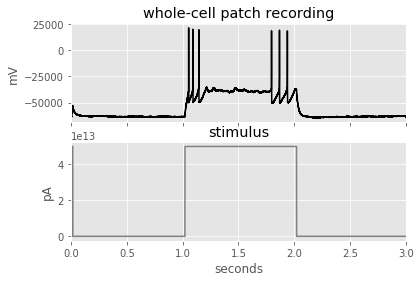

In [10]:
index_range = sweep_data["index_range"]
i = sweep_data["stimulus"][0:index_range[1]+1] # in A
v = sweep_data["response"][0:index_range[1]+1] # in V
i *= 1e12 # this converts the value to pA
v *= 1e3 # this converts the value to mV

sampling_rate = sweep_data["sampling_rate"] # in Hz
t = (np.arange(0, len(v)) * (1.0 / sampling_rate))

plt.style.use('ggplot')
fig, axes = plt.subplots(2, 1, sharex=True)

# axes 0 is our first plot, of the recorded voltage data
axes[0].plot(t, v, color='black')
axes[0].set_ylabel("mV")
#axes[0].set_xlim(0,3)
axes[0].set_title("whole-cell patch recording")

#axes 1 is our second plot, of the stimulus trace
axes[1].plot(t, i, color='gray')
axes[1].set_ylabel("pA")
axes[1].set_xlabel("seconds")
axes[1].set_title("stimulus")

plt.show()

This plot probably looks different from the plot on the website, why?

<b>Hint:</b> There is a line that has been commented out above. Uncomment the line to change the scaling of the x-axis in order to zoom in on the period where the current was applied. If necessary, change the second value in set_xlim to change the extent of the x axis. Re-run the cell to re-plot the data.

## Step 3 Plotting the morphology of the cell
The Cell Types Database also contains 3D reconstructions of neuronal morphologies. Here, we'll plot the reconstruction of our cell's morphology. <b>It may take a minute or two to run the cell below.</b>

2019-04-17 14:22:58,365 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/491120375
2019-04-17 14:22:59,096 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/501275935


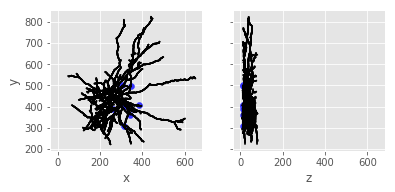

In [11]:
import pprint

# download and open SWC and marker files
morphology = ctc.get_reconstruction(cell_id) 
markers = ctc.get_reconstruction_markers(cell_id) 

# plot
from allensdk.core.swc import Marker
fig, axes = plt.subplots(1, 2, sharey=True, sharex=True)
axes[0].set_aspect('equal')
axes[1].set_aspect('equal')

# Make a line drawing of x-y and y-z views
for n in morphology.compartment_list:
    for c in morphology.children_of(n):
        axes[0].plot([n['x'], c['x']], [n['y'], c['y']], color='black')
        axes[1].plot([n['z'], c['z']], [n['y'], c['y']], color='black')

# cut dendrite markers
dm = [ m for m in markers if m['name'] == Marker.CUT_DENDRITE ]
axes[0].scatter([m['x'] for m in dm], [m['y'] for m in dm], color='#3333ff')
axes[1].scatter([m['z'] for m in dm], [m['y'] for m in dm], color='#3333ff')

# no reconstruction markers
nm = [ m for m in markers if m['name'] == Marker.NO_RECONSTRUCTION ]
axes[0].scatter([m['x'] for m in nm], [m['y'] for m in nm], color='#333333')
axes[1].scatter([m['z'] for m in nm], [m['y'] for m in nm], color='#333333')
axes[0].set_ylabel('y')
axes[0].set_xlabel('x')
axes[1].set_xlabel('z')
plt.show()

## Step 4: Filtering Cells via Metadata (information about those cells)

Cell records in the Cell Types Database come with a large amount of metadata. We can use "CellTypesCache.get_cells" to specify which cells we want.

First, let's get an idea of all of the data that exists for us to analyze.

The Cell Types Database contains a set of features that have already been computed, which could serve as good starting points for analysis. We can query the database to get these features. Let's first see which features are available.

<b>Note</b> you may get an error that says 'from_csv is deprecated' while running this, but it won't disrupt the script. You can ignore it.

In [12]:
import pandas as pd

# download all electrophysiology features for all cells
ephys_features = ctc.get_ephys_features()
ef_df = pd.DataFrame(ephys_features)

print("Ephys features available for %d cells" % len(ef_df))

# look at the features available for our cell
cell_ephys_features = ef_df[ef_df['specimen_id']== cell_id]
cell_ephys_features

/datasets/home/61/361/ajuavine/.local/lib/python3.6/site-packages/allensdk/api/cache.py:386: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  'reader': lambda f: pd.DataFrame.from_csv(f).to_dict('records')


Ephys features available for 2333 cells


,avg_isi,electrode_0_pa,f_i_curve_slope,fast_trough_t_long_square,fast_trough_t_ramp,fast_trough_t_short_square,fast_trough_v_long_square,fast_trough_v_ramp,fast_trough_v_short_square,has_burst,...,trough_t_ramp,trough_t_short_square,trough_v_long_square,trough_v_ramp,trough_v_short_square,upstroke_downstroke_ratio_long_square,upstroke_downstroke_ratio_ramp,upstroke_downstroke_ratio_short_square,vm_for_sag,vrest
1542,34.796538,15.709375,0.575532,1.10479,2.759537,1.02487,-50.8125,-48.989586,-52.523439,False,...,2.767942,1.540014,-51.500004,-50.885419,-63.67969,2.329841,2.036241,2.32015,-100.5,-62.611252


That's how to get all the ephys features for a given specimen - what if we want a particular feature for all cells? Let's first look at the speed of the trough, and the ratio between the upstroke and downstroke of the action potential.

<div style="background: #F3D48D; border-radius: 3px; padding: 10px;">

<b>Action potential fast trough (fast_trough_v_long_square)</b>: Minimum value of the membrane potential in the interval lasting 5 ms after the peak.

<b>Upstroke/downstroke ratio (upstroke_downstroke_ratio_long_square)</b>: The ratio between the absolute values of the action potential peak upstroke and the action potential peak downstroke.</div> 

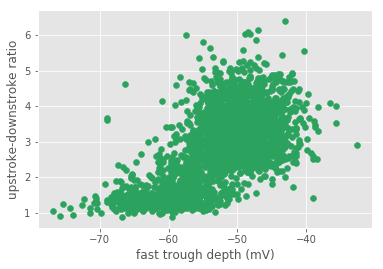

In [13]:
plt.figure()
plt.scatter(ef_df['fast_trough_v_long_square'], 
            ef_df['upstroke_downstroke_ratio_long_square'],
            color='#2ca25f')
plt.ylabel("upstroke-downstroke ratio")
plt.xlabel("fast trough depth (mV)")
plt.show()

It looks like there may be roughly two clusters in the data above. Maybe they relate to whether the cells are presumably excitatory (spiny) cells or inhibitory (aspiny) cells. Let's query the API and split up the two sets to see.

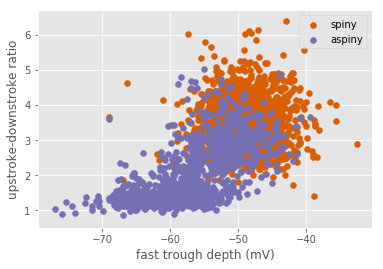

In [14]:
cells = ctc.get_cells()

# we want to add dendrite type as a column to the ephys. features dataframe
# first build an index on cell specimen ID, then create array of dendrite types
cell_index = { c['id']: c for c in cells }
dendrite_types = [ cell_index[cid]['dendrite_type'] for cid in ef_df['specimen_id'] ]

# now add the new column
ef_df['dendrite_type'] = pd.Series(dendrite_types, index=ef_df.index)

fig = plt.figure()
for d_type, color in [ ["spiny", "#d95f02"], ["aspiny", "#7570b3"] ]:
    df = ef_df[ef_df['dendrite_type'] == d_type]
    plt.scatter(df['fast_trough_v_long_square'], 
                df['upstroke_downstroke_ratio_long_square'], 
                color=color, label=d_type)
    plt.ylabel("upstroke-downstroke ratio")
    plt.xlabel("fast trough depth (mV)")
    plt.legend(loc='best')
    
plt.show()

Looks like these two clusters do partially relate to the dendritic type. Cells with spiny dendrites (which are typically excitatory cells) have a big ratio of upstroke:downstroke, and a more shallow trough (less negative). Cells with aspiny dendrites (typically inhibitory cells) are a little bit more varied. But </i>only</i> aspiny cells have a low upstroke:downstroke ratio and a deeper trough (more negative).

Let's take a closer look at the action potentials of these cells to see what these metrics actually mean for the action potential waveform by choosing one of the cells with the highest upstroke:downstroke ratio.

In [15]:
ef_df_upstroke_sorted = ef_df.sort_values('upstroke_downstroke_ratio_long_square',ascending=False)
top_cell = ef_df_upstroke_sorted.iloc[2]
cell_id = top_cell['specimen_id']
cell_id
print('Cell with biggest upstroke:downstroke ratio')
print("Specimen ID: %d" % cell_id)
print("With ratio: %s" % top_cell['upstroke_downstroke_ratio_long_square'])

Cell with biggest upstroke:downstroke ratio
Specimen ID: 510106222
With ratio: 6.096556072935241


Now we can take a closer look at the action potential for that cell by grabbing its electrophysiology data, just like we did above. Let's fine a good sweep that will show us some nice action potentials. The next cell of code will look for sweep numbers with a Long Square stimulus of at least 200 pA. It'll print some sweep IDs.

In [16]:
upstroke_data = ctc.get_ephys_data(cell_id)
print('Upstroke sample cell data acquired')
sweepIDs = upstroke_data.get_sweep_numbers()
sweepNum = len(sweepIDs)
for i in range(1,sweepNum):
    sweepMeta = upstroke_data.get_sweep_metadata(sweepIDs[i])
    if sweepMeta['aibs_stimulus_name'] == 'Long Square':
        if sweepMeta['aibs_stimulus_amplitude_pa'] > 200:
            # print(sweepMeta)
            print(sweepIDs[i])

2019-04-17 14:37:33,465 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/567445815


Upstroke sample cell data acquired
45
46
47


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <b>Task</b>: Enter one of these sweep IDs in the next cell where it says "upstroke_sweep_id".</div>

In [37]:
# choose a sweep number to plot
upstroke_sweep_id = 
upstroke_sweep = upstroke_data.get_sweep(upstroke_sweep_id) 

And now let's plot our sweep, zooming in on the action potential. You may need to change some values in the plotting script, or change the sweep number to one where you can see an action potential.

In [38]:
index_range = upstroke_sweep["index_range"]
i = upstroke_sweep["stimulus"][0:index_range[1]+1] # in A
v = upstroke_sweep["response"][0:index_range[1]+1] # in V
i *= 1e12 # this converts the value to pA
v *= 1e12 # this converts the value to mV

sampling_rate = sweep_data["sampling_rate"] # in Hz
t = (np.arange(0, len(v)) * (1.0 / sampling_rate))

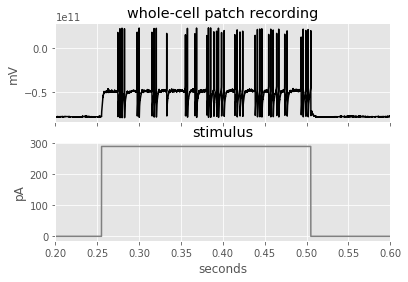

In [41]:
plt.style.use('ggplot')
fig, axes = plt.subplots(2, 1, sharex=True)

# axes 0 is our first plot, of the recorded voltage data
axes[0].plot(t, v, color='black')
axes[0].set_ylabel("mV")
#axes[0].set_xlim(0,1)
axes[0].set_title("whole-cell patch recording")

#axes 1 is our second plot, of the stimulus trace
axes[1].plot(t, i, color='gray')
axes[1].set_ylabel("pA")
axes[1].set_xlabel("seconds")
axes[1].set_title("stimulus")

plt.show()

Let's do the same thing for a cell with a low upstroke ratio and compare. Similiar to above, zoom in on the x axis so that you can actually see the shape of the waveform.

In [42]:
ef_df_upstroke_sorted = ef_df.sort_values('upstroke_downstroke_ratio_long_square',ascending=True)
top_cell = ef_df_upstroke_sorted.iloc[2]
cell_id = top_cell['specimen_id']
print("Specimen ID: %d" % cell_id)
print("With ratio: %s" % top_cell['upstroke_downstroke_ratio_long_square'])
upstroke_data = ctc.get_ephys_data(cell_id)
upstroke_sweep = upstroke_data.get_sweep(46) 
index_range = upstroke_sweep["index_range"]
i_2 = upstroke_sweep["stimulus"][0:index_range[1]+1] # in A
v_2 = upstroke_sweep["response"][0:index_range[1]+1] # in V
i_2 *= 1e12 # this converts the value to pA
v_2 *= 1e12 # this converts the value to mV

sampling_rate = sweep_data["sampling_rate"] # in Hz
t_2 = (np.arange(0, len(v_2)) * (1.0 / sampling_rate))

Specimen ID: 569991910
With ratio: 0.906845223777635


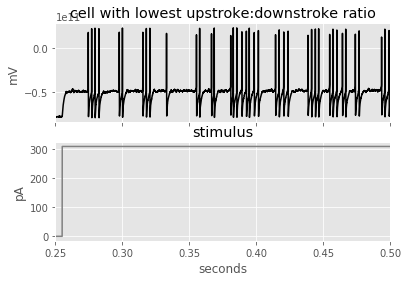

In [44]:
plt.style.use('ggplot')
fig, axes = plt.subplots(2, 1, sharex=True)

axes[0].plot(t, v, color='black')
axes[0].set_ylabel("mV")
#axes[0].set_xlim(0,1)
axes[0].set_title("cell with lowest upstroke:downstroke ratio")

axes[1].plot(t_2, i_2, color='gray')
axes[1].set_ylabel("pA")
axes[1].set_xlabel("seconds")
axes[1].set_title("stimulus")

plt.show()

As you can see, even that one metric, upstroke:downstroke ratio, means the shape of the action potential is dramatically different. The other metric above, size of the trough, is highly correlated with upstroke:downstroke. You can see that by comparing the two cells here. Cells with high upstroke:downstroke tend to have less negative troughs (undershoots) after the action potential.

## Step 5: Comparing human to mouse cells
Let's get out of the action potential weeds a bit. What if we want to know a big picture thing, such as <b>are human cells different than mouse cells?</b>
    
We can make similar plots to above but subselected for human and mouse cells. First, let's get an idea of how many cells of each type are here.

In [45]:
from allensdk.api.queries.cell_types_api import CellTypesApi
from allensdk.core.cell_types_cache import ReporterStatus as RS
# download all cells
cells = ctc.get_cells()
print("Total cells: %d" % len(cells))
# mouse cells
cells = ctc.get_cells(species=[CellTypesApi.MOUSE])
print("Mouse cells: %d" % len(cells))
# human cells
cells = ctc.get_cells(species=[CellTypesApi.HUMAN])
print("Human cells: %d" % len(cells))

Total cells: 2333
Mouse cells: 1920
Human cells: 413


Let's now get all of the electrophysiology data for the mouse and human cells, separately.

In [46]:
# make a dataframe out of ephys features
ephys_features_df = pd.DataFrame.from_records(ephys_features)
ephys_features_df.head(1)

# grab mouse data and merge with dataframe
mouse_cells = ctc.get_cells(species=[CellTypesApi.MOUSE])
mouse_df = pd.DataFrame(mouse_cells)
mouse_ephys_df = pd.merge(mouse_df,ephys_features_df,left_on='id',right_on='specimen_id',how='left')

# grab human data and merge with dataframe
human_cells = ctc.get_cells(species=[CellTypesApi.HUMAN])
human_df = pd.DataFrame(human_cells)
human_ephys_df = pd.merge(human_df,ephys_features_df,left_on='id',right_on='specimen_id',how='left')

Let's look at the first five rows of our mouse and human datasets here.

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <b>Task</b>: Show the first few rows of the table by using brackets after the variable name. Look above to see which variable your merged dataframe is saved as. Then, you'll you want to enter variable_name[1:5]. Do this for the mouse data in the first cell below, and human data in the second. Scroll to the right within the table to see the parameters for the cell.</div>

,apical,cell_soma_location,dendrite_type,disease_state,donor_id,id_x,name,normalized_depth,reconstruction_type,reporter_status,...,trough_t_ramp,trough_t_short_square,trough_v_long_square,trough_v_ramp,trough_v_short_square,upstroke_downstroke_ratio_long_square,upstroke_downstroke_ratio_ramp,upstroke_downstroke_ratio_short_square,vm_for_sag,vrest
1,NA,"[7872.53138541818, 993.212032389272, 3127.1530...",aspiny,,319194354,469801138,Pvalb-IRES-Cre;Ai14-170927.05.02.01,0.469578,None,positive,...,11.763808,1.290815,-55.875000,-52.515627,-69.109379,1.162618,1.197155,1.369171,-80.156250,-72.042976
2,NA,"[9400.0, 1520.74232706376, 2188.13845194139]",aspiny,,605622695,605889373,Vipr2-IRES2-Cre;Slc32a1-T2A-FlpO;Ai65-337419.0...,NaN,None,positive,...,8.432940,1.315510,-48.187500,-54.364586,-72.640628,3.379321,4.108774,2.680139,-83.593758,-72.712036
3,intact,"[8881.0, 953.839501299405, 7768.22695782726]",spiny,,485250100,485909730,Cux2-CreERT2;Ai14-205530.03.02.01,0.478344,dendrite-only,positive,...,2.888133,1.520193,-54.031254,-57.385419,-77.750005,3.042933,3.517684,3.274181,-101.000000,-76.928391
4,intact,"[8125.0, 904.841803028986, 7819.69986630448]",spiny,,322489588,323865917,Scnn1a-Tg3-Cre;Ai14-172530.06.01.01,0.608590,dendrite-only,positive,...,3.467847,1.317042,-57.281254,-56.895833,-70.218751,2.974194,3.156117,2.946463,-88.406250,-69.402855


Let's start by plotting the resting membrane potential for all of our human cells vs all of our mouse cells.

(In case you're curious, here's a good place to find documentation for plotting: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.plot.html You can always Google questions you have!)

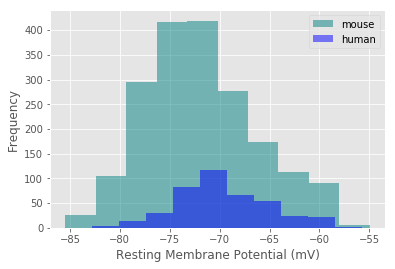

In [48]:
fig = plt.figure()

# Below it is set to plot resting membrane potential 'vrest'. That's where you can change what is being plotted.
# Make sure you change it for both the mouse and human plot!
axes = mouse_ephys_df['vrest'].plot(kind="hist",fc=(0, .5,.5, 0.5))
axes = human_ephys_df['vrest'].plot(kind="hist",fc=(0, 0, 1, 0.5))

# this is where you should change the label:
axes.set_xlabel('Resting Membrane Potential (mV)')
axes.legend(['mouse','human'])
plt.show()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <b>Task</b>: Choose a different parameter to compare between human and mouse cells, and rerun the plot above. Use the tables above to get the exact name of the parameter, and change the x label axis so that we know what you're plotting.

Save your figure by right clicking on the image above. You'll need to submit this on Canvas.</div>

### Subselect for spiny or aspiny cells.
Final step for today! The histogram above is for <i>all cell types</i>, which is a really hetergenous bunch.

What happens if we subselect our human and mouse cells to be just spiny, or just aspiny? Will those types be more different in humans and mice?

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <b>Task</b>: Decide whether you want to look at spiny or aspiny cells. Replace CELLTYPE below with your choice. The variable name <u>should not</u> have quotes. The logical argument within <u>should</u> have quotes.</div>

Number of human CELLTYPE cells: 79
Number of mouse CELLTYPE cells: 921


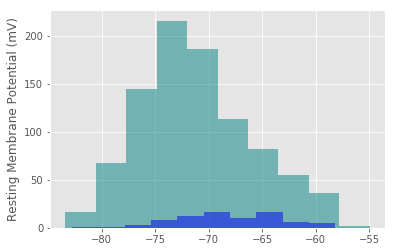

In [50]:
# select cells that are only spiny or aspiny. You can change aspiny to spiny, if you'd like.
human = human_ephys_df[human_ephys_df['dendrite_type']=='CELLTYPE']
mouse = mouse_ephys_df[mouse_ephys_df['dendrite_type']=='CELLTYPE']
print('Number of human CELLTYPE cells: %d' % len(human))
print('Number of mouse CELLTYPE cells: %d' % len(mouse))

fig = plt.figure()
# Below it is set to plot resting membrane potential 'vrest'. That's where you can change what is being plotted.
# Make sure you change it for both the mouse and human plot!

axes = mouse['vrest'].plot(kind="hist",fc=(0, .5,.5, 0.5))
axes = human['vrest'].plot(kind="hist",fc=(0, 0, 1, 0.5))
axes.set_ylabel('Resting Membrane Potential (mV)')

#cells_concat = pd.concat([aspiny_mouse['vrest'],aspiny_human['vrest']],axis=1)
#cells_concat.columns = ['mouse','human']
#cells_concat.boxplot()
# plt.ylabel('Resting Membrane Potential (mv)')

plt.show()

It's a little hard to see differences here, so let's plot it as a boxplot. Comment out the lines above that start with "axes=" and uncomment the four lines below. Re-run the code to get a boxplot of the data.

Change the metric here to whatever metric you created and saved a histogram for above. Save your image when you're done.

Upload your two images to "Computer Lab 1" on Canvas when you're done. You should also enter your answers to the worksheet on Canvas.

Nice work!

In [ ]:
from IPython.display import HTML
HTML('<img src="https://media.giphy.com/media/xUOwGhOrYP0jP6iAy4/giphy.gif">')

-----------

##### Technical notes

This notebook demonstrates most of the features of the AllenSDK that help manipulate data in the Cell Types Database.  The main entry point will be through the `CellTypesCache` class. `CellTypesCache` is responsible for downloading Cell Types Database data to a standard directory structure on your hard drive.  If you use this class, you will not have to keep track of where your data lives, other than a root directory.

Much more information can be found in the Allen Brain Atlas whitepaper, here: http://help.brain-map.org/display/celltypes/Documentation?preview=/8323525/10813529/CellTypes_Ephys_Overview.pdf.

This file modified from <a href='cell_types.ipynb'>this</a> notebook.